# AlgebraicMetabolism Package Demo

First we want to load our package with `using`, we will also want some Catlab utilities.

In [1]:
using AlgebraicMetabolism
using Catlab
using Catlab.ACSets
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Test

The first step is to understand the data model of what metabolic network is

There are sets:

 1. V the vertices, which represent variables in the system
 2. E₁ the edges that represent coefficients
 3. E₂ the edges that represent exponents
 4. Names for using human readable variable names
 5. Numbers for storing coefficients and exponents

Then there are relationships:
 1. src₁,tgt₁ for encoding a graph of coefficients
 2. src₂,tgt₂ for encoding a graph of exponents
 3. μ,f tell you the numeric value associated with that edge
 4. γ an intrinsic parameter for the strength of effects per vertex
 5. vname gives you the vertex names

We did not name the edges, because they don't really have conceptual identities
other than "the interaction between x,y" where x is the src and y is the target variables.

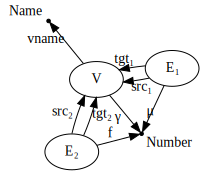

In [2]:
to_graphviz(SchReactionMetabolicNet)

The schema definition is given in the following domain specific language (DSL) invented by Catlab.

```julia
@present SchMetabolicNet(FreeSchema) begin
  (V, E₁, E₂)::Ob
  src₁::Hom(E₁, V)
  tgt₁::Hom(E₁, V)

  src₂::Hom(E₂, V)
  tgt₂::Hom(E₂, V)
end

@present SchReactionMetabolicNet <: SchMetabolicNet begin
  Name::AttrType

  vname::Attr(V, Name)

  Number::AttrType
  γ::Attr(V, Number)
  μ::Attr(E₁, Number)
  f::Attr(E₂, Number)

end
```

Once we define the schema, Catlab will generate a domain specific language for specifying models.
This language isn't the easiest to write, but it is completely generated from the specification of the schema,
and works for any type of model that you can build.

In [3]:
#Let's make our first model

M = @acset ReactionMetabolicNet{Rational} begin
  V = 3
  E₁ = 2
  E₂ = 3
  vname = [:x₁, :x₂, :x₃]
  γ = [1//2, 1//3, 2]

  src₁ = [1,2]
  tgt₁ = [2,3]
  μ = [7,11]

  src₂ = [1,2,3]
  tgt₂ = [2,3,3]
  f = [1,2,3]
end

ReactionMetabolicNet{Rational} with elements V = 1:3, E₁ = 1:2, E₂ = 1:3, Name = 1:0, Number = 1:0
┌───┬───────┬──────┐
│ V │ vname │    γ │
├───┼───────┼──────┤
│ 1 │    x₁ │ 1//2 │
│ 2 │    x₂ │ 1//3 │
│ 3 │    x₃ │ 2//1 │
└───┴───────┴──────┘
┌────┬──────┬──────┬───────┐
│ E₁ │ src₁ │ tgt₁ │     μ │
├────┼──────┼──────┼───────┤
│  1 │    1 │    2 │  7//1 │
│  2 │    2 │    3 │ 11//1 │
└────┴──────┴──────┴───────┘
┌────┬──────┬──────┬──────┐
│ E₂ │ src₂ │ tgt₂ │    f │
├────┼──────┼──────┼──────┤
│  1 │    1 │    2 │ 1//1 │
│  2 │    2 │    3 │ 2//1 │
│  3 │    3 │    3 │ 3//1 │
└────┴──────┴──────┴──────┘

We should visually inspect our model with graphviz rendering

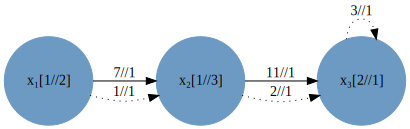

In [4]:
to_graphviz(M)

We can compute the dynamics equation from the model with `dynamics_expr`

In [5]:
@show dynamics_expr(M)

dynamics_expr(M) = quote
    #= /home/runner/work/AlgebraicMetabolism.jl/AlgebraicMetabolism.jl/src/AlgebraicMetabolism.jl:124 =#
    d.x₁ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 7//1 * 1 * 1 * x₃ ^ 2//1 + 0//1 * 1 * 1 * x₃ ^ 3//1
    d.x₂ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 0//1 * 1 * 1 * x₃ ^ 2//1 + 11//1 * 1 * 1 * x₃ ^ 3//1
    d.x₃ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 0//1 * 1 * 1 * x₃ ^ 2//1 + 0//1 * 1 * 1 * x₃ ^ 3//1
end


quote
    #= /home/runner/work/AlgebraicMetabolism.jl/AlgebraicMetabolism.jl/src/AlgebraicMetabolism.jl:124 =#
    d.x₁ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 7//1 * 1 * 1 * x₃ ^ 2//1 + 0//1 * 1 * 1 * x₃ ^ 3//1
    d.x₂ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 0//1 * 1 * 1 * x₃ ^ 2//1 + 11//1 * 1 * 1 * x₃ ^ 3//1
    d.x₃ = 0//1 * 1 * x₂ ^ 1//1 * 1 + 0//1 * 1 * 1 * x₃ ^ 2//1 + 0//1 * 1 * 1 * x₃ ^ 3//1
end

Because these models are defined as a presheaf category, they come with
a lattice of subobjects. This works like subsets of a set, but will respect
the connectivity structure of the model.

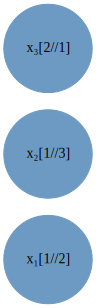

In [6]:
X1 = Subobject(M, V=[1])
X2 = Subobject(M, V=[2])
X3 = Subobject(M, V=[3])

draw_subobject(join(join(X1, X2), X3))

From the isolate vertices shown above we can compute the "model complement"
with the negation operator. For example, the complement of X3 is
X1 and X2 and all their interactions.

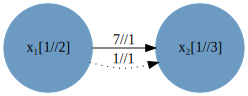

In [7]:
negate(X3) |> draw_subobject

And the complement of X1 is X2 and X3 with all their interactions.

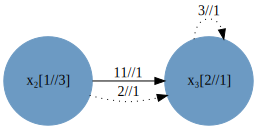

In [8]:
negate(X1) |> draw_subobject

The meet and join operators play the role of union and intersection

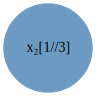

In [9]:
meet(negate(X3), negate(X1)) |> draw_subobject

But I always forget which is which!

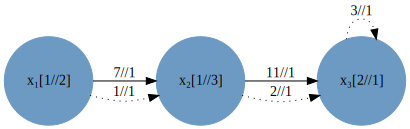

In [10]:
join(negate(X3), negate(X1)) |> draw_subobject

Most of your propositional logic rules apply in this lattice.

In [11]:
is_subobject(X3, negate(join(X1, X2)))

true

The biggest difference is that double negation is not the identity.
While join(X1,X2) has 2 vertices and no edges,
¬¬(X1 ∨ X2) has 2 vertices and 2 edges!
Double negation can be used to define the "induced subgraph" operator
for any class of models.

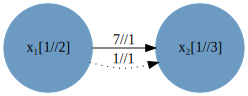

In [12]:
negate(negate(join(X1, X2))) |> draw_subobject